In [129]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/deep_learning_from_scratch/

/content/gdrive/My Drive/deep_learning_from_scratch


In [2]:
import numpy as np
from common.layers import Softmax

In [3]:
from common.seq2seq import Encoder, Seq2seq

In [4]:
from common.time_layers import TimeEmbedding, TimeSoftmaxWithLoss, TimeAffine, TimeLSTM

In [5]:
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

In [6]:
import matplotlib.pyplot as plt

In [7]:
import pickle

# Improve Encoder and Decoder

## Context Vector

Train a weight (or vector) to multiply the hidden state vectors over the whole time from encoder (a.k.a. `hs`). This represents paying a attention to the important time. 

In [136]:
T, H = 5, 4
hs = np.random.randn(T, H)

# attention weights representing the weights for each time point
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])

ar = a.reshape(-1, 1).repeat(4, axis=1)
print("attention weights shape: {}".format(ar.shape))

t = hs * ar
print("time point * attention weights: {}".format(t.shape))

# context vector
c = np.sum(t, axis=0)
print("context vector shape: {}".format(c.shape))

attention weights shape: (5, 4)
time point * attention weights: (5, 4)
context vector shape: (4,)


In batch data.

In [137]:
N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)

# attention weights
a = np.random.randn(N, T)
ar = a.reshape(N, T, 1).repeat(H, axis=2)
print("attention weight shape: {}".format(ar.shape))

t = hs * ar
print("time point * attention weight: shape is {}".format(t.shape))

# context vector in batch data
c = np.sum(t, axis=1)
print("context vector shape in batch: {}".format(c.shape))

attention weight shape: (10, 5, 4)
time point * attention weight: shape is (10, 5, 4)
context vector shape in batch: (10, 4)


In [0]:
class WeightSum:
  def __init__(self):
    self.params, self.grads = [], []
    self.cache = None
  
  def forward(self, hs, a):
    N, T, H = hs.shape
    ar = a.reshape(N,T,1).repeat(H, axis=2)
    t = hs * ar
    c = np.sum(t, axis=1)  # shape = N x H
    self.cache = (hs, ar)
    return c
  
  def backward(self, dc):
    """
    dc = N x H
    """
    
    hs, ar = self.cache
    N, T, H = hs.shape
    
    dt = dc.reshape(N, 1, H).repeat(T, axis=1)  # backpropagation of sum ops
    dar = dt * hs   # shape = (N, T, H)
    dhs = dt * ar
    da = np.sum(dar, axis=2)   # shape = (N, T), backpropagation of repeat ops
    
    return dhs, da

## Learning Attention Weights

In [139]:
N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)

# from LSTM
h = np.random.randn(N, H)
hr = h.reshape(N, 1, H).repeat(T, axis=1)

# similar to inner product of two vectors
# here we want to get attention weight
# we sum hidden values (axis=2)
t = hs * hr
print(t.shape)
s = np.sum(t, axis=2)
print(s.shape)

softmax = Softmax()
a = softmax.forward(s)
print(a.shape)
print(np.sum(a[1]))

(10, 5, 4)
(10, 5)
(10, 5)
1.0


In [0]:
class AttentionWeight:
  def __init__(self):
    self.params, self.grads = [], []
    self.softmax = Softmax()
    self.cache = None
  
  def forward(self, hs, h):
    N, T, H = hs.shape
    hr = h.reshape(N, 1, H).repeat(T, axis=1)
    t = hs * hr
    s = np.sum(t, axis=2)
    a = self.softmax.forward(s)
    
    self.cache = (hs, hr)
    return a
  
  def backward(self, da):
    hs, hr = self.cache
    N, T, H = hs.shape
    
    ds = self.softmax.backward(da)   # (N, T)
    dt = ds.reshape(N, T, 1).repeat(H, axis=2)  # (N, T, H)
    dhs = dt * hr
    dhr = dt * hs
    dh = np.sum(dhr, axis=1)
    
    return dhs, dh

## Attention

Attention layer is sequentially composed of two sub-layers, `AttentionWeight` and `WeightSum`.

In [0]:
class Attention:
  def __init__(self):
    self.params, self.grads = [], []
    self.attention_weight_layer = AttentionWeight()
    self.weight_sum_layer = WeightSum()
    self.attention_weight = None
  
  def forward(self, hs, h):
    """
    hs shape: (N, T, H)
    h shape: (H, H)
    """
    aw = self.attention_weight_layer.forward(hs, h)
    context = self.weight_sum_layer.forward(hs, aw)
    self.attention_weight = aw
    return context
  
  def backward(self, dout):
    dhs0, da = self.weight_sum_layer.backward(dout)
    dhs1, dh = self.attention_weight_layer.backward(da)
    dhs = dhs0 + dhs1
    return dhs, dh

## Time Attention

In [0]:
class TimeAttention:
  def __init__(self):
    self.params, self.grads = [], []
    self.layers = None
    self.attention_weights = None
  
  def forward(self, hs_enc, hs_dec):
    N, T, H = hs_dec.shape
    out = np.empty_like(hs_dec)
    self.layers = []
    self.attention_weights = []
    
    for t in range(T):
      layer = Attention()
      out[:, t, :] = layer.forward(hs_enc, hs_dec[:, t, :])
      self.layers.append(layer)
      self.attention_weights.append(layer.attention_weight)
    
    return out
  
  def backward(self, dout):
    N, T, H = dout.shape
    dhs_enc = 0
    dhs_dec = np.empty_like(dout)
    
    for t in range(T):
      layer = self.layers[t]
      dhs, dh = layer.backward(dout[:,t,:])
      dhs_enc += dhs
      dhs_dec[:, t, :] = dh
      
    return dhs_enc, dhs_dec

# Seq2Seq with Attention Mechanism

## AttentionEncoder

In [0]:
class AttentionEncoder(Encoder):
  def forward(self, xs):
    xs = self.embed.forward(xs)
    hs = self.lstm.forward(xs)
    self.hs = hs
    return self.hs
  
  def backward(self, dh):
    dout = self.lstm.backward(dh)
    dout = self.embed.backward(dout)
    return dout

## AttentionEncoder

In [0]:
class AttentionDecoder:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn
    self.params, self.grads = [], []
    
    # weight initialization
    embed_W = (rn(V, D) / 100).astype('f')
    lstm_Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
    lstm_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
    lstm_b = (np.zeros(4*H)).astype('f')
    affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
    affine_b = (np.zeros(V)).astype('f')
    
    # layers
    self.embed = TimeEmbedding(embed_W)
    self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
    self.attention = TimeAttention()
    self.affine = TimeAffine(affine_W, affine_b)
    
    layers = [self.embed, self.lstm, self.attention, self.affine]
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads
    
    
  def forward(self, xs, enc_hs):
    embed = self.embed.forward(xs)
    
    h = enc_hs[:,-1]
    self.lstm.set_state(h)
    dec_hs = self.lstm.forward(embed)
    
    c = self.attention.forward(enc_hs, dec_hs)
    out = np.concatenate((c, dec_hs), axis=2)
    score = self.affine.forward(out)
    return score
  
  def backward(self, dscore):
    dout = self.affine.backward(dscore)
    N, T, H2 = dout.shape
    H = H2 // 2
    
    dc, dhs_dec0 = dout[:,:,:H], dout[:,:,H:]
    dhs_enc, dhs_dec1 = self.attention.backward(dc)
    
    dhs_dec = dhs_dec0 + dhs_dec1
    dxs = self.lstm.backward(dhs_dec)
    dh = self.lstm.dh
    
    dhs_enc[:, -1] += dh
    self.embed.backward(dxs)
    
    return dhs_enc
  
  def generate(self, h, start_id, sample_size):
    sampled = []
    sample_id = start_id
    
    _h = h[:,-1]
    self.lstm.set_state(_h)
    
    for _ in range(sample_size):
      x = np.array([sample_id]).reshape(1,1)
      
      embed = self.embed.forward(x)
      hs_dec = self.lstm.forward(embed)
      c = self.attention.forward(h, hs_dec)
      out = np.concatenate((c, hs_dec), axis=2)
      score = self.affine.forward(out)
      
      sample_id = np.argmax(score.flatten())
      sampled.append(sample_id)
      
    return sampled

## AttentionSeq2Seq

In [0]:
class AttentionSeq2Seq(Seq2seq):
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    args = vocab_size, wordvec_size, hidden_size
    
    # create layers
    self.encoder = AttentionEncoder(*args)
    self.decoder = AttentionDecoder(*args)
    self.softmax = TimeSoftmaxWithLoss()
    
    self.params = self.encoder.params + self.decoder.params
    self.grads = self.encoder.grads + self.decoder.grads

## Training

In [0]:
# load data
(x_train, t_train), (x_test, t_test) = sequence.load_data("./dataset/date.txt")
char_to_id, id_to_char = sequence.get_vocab()

# reverse the input sequence
x_train, x_test = x_train[:,::-1], x_test[:,::-1]

In [0]:
print(char_to_id)

{'s': 0, 'e': 1, 'p': 2, 't': 3, 'm': 4, 'b': 5, 'r': 6, ' ': 7, '2': 8, '7': 9, ',': 10, '1': 11, '9': 12, '4': 13, '_': 14, '-': 15, '0': 16, 'A': 17, 'u': 18, 'g': 19, '3': 20, '8': 21, '/': 22, 'T': 23, 'U': 24, 'E': 25, 'S': 26, 'D': 27, 'Y': 28, 'P': 29, 'M': 30, 'B': 31, 'R': 32, '5': 33, 'J': 34, 'N': 35, '6': 36, 'a': 37, 'i': 38, 'l': 39, 'O': 40, 'c': 41, 'o': 42, 'G': 43, 'F': 44, 'y': 45, 'n': 46, 'C': 47, 'W': 48, 'd': 49, 'I': 50, 'L': 51, 'j': 52, 'H': 53, 'v': 54, 'h': 55, 'V': 56, 'f': 57, 'w': 58}


In [0]:
# hyperparameters
vocab_size = len(id_to_char)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

In [0]:
model = AttentionSeq2Seq(vocab_size, wordvec_size, hidden_size)

In [0]:
optimizer = Adam()
trainer = Trainer(model=model, optimizer=optimizer)

In [0]:
# start training
acc_list = []

for epoch in range(max_epoch):
  trainer.fit(x_train, t_train, max_epoch=1, 
              batch_size=batch_size, max_grad=max_grad)
  correct_num = 0
  for i in range(len(x_test)):
    question, correct = x_test[[i]], t_test[[i]]
    verbose = i < 10
    correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse=True)
    
  acc = float(correct_num) / len(x_test)
  acc_list.append(acc)
  print("accuracy: {:3f}".format(acc))

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 4.08
| epoch 1 |  iter 21 / 351 | time 13[s] | loss 3.09
| epoch 1 |  iter 41 / 351 | time 26[s] | loss 1.90
| epoch 1 |  iter 61 / 351 | time 39[s] | loss 1.72
| epoch 1 |  iter 81 / 351 | time 51[s] | loss 1.46
| epoch 1 |  iter 101 / 351 | time 64[s] | loss 1.19
| epoch 1 |  iter 121 / 351 | time 77[s] | loss 1.14
| epoch 1 |  iter 141 / 351 | time 90[s] | loss 1.09
| epoch 1 |  iter 161 / 351 | time 104[s] | loss 1.06
| epoch 1 |  iter 181 / 351 | time 118[s] | loss 1.04
| epoch 1 |  iter 201 / 351 | time 130[s] | loss 1.03
| epoch 1 |  iter 221 / 351 | time 143[s] | loss 1.02
| epoch 1 |  iter 241 / 351 | time 155[s] | loss 1.02
| epoch 1 |  iter 261 / 351 | time 168[s] | loss 1.01
| epoch 1 |  iter 281 / 351 | time 182[s] | loss 1.00
| epoch 1 |  iter 301 / 351 | time 194[s] | loss 1.00
| epoch 1 |  iter 321 / 351 | time 206[s] | loss 1.00
| epoch 1 |  iter 341 / 351 | time 219[s] | loss 1.00
Q 10/15/94                     
T 1994-10-1

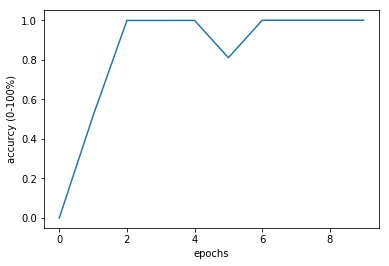

In [0]:
plt.plot(acc_list)
plt.xlabel("epochs")
plt.ylabel("accurcy (0-100%)")
plt.show()

In [0]:
model.save_params("./tmp/attentionseq2seq.pkl")

In [0]:
model.load_params("./tmp/attentionseq2seq.pkl")

## Visualization

In [0]:
test_id = 10
print(x_test[test_id])
print(''.join([id_to_char[w] for w in x_test[test_id]]))

[ 7  7  7  7  7  7  7  7  8 12 12 11  7 10 13 11  7  1 46 18 34  7 10 45
 37 49 46 18 26]
        2991 ,41 enuJ ,yadnuS


In [0]:
xs = np.array([x_test[test_id]]).reshape(1, -1)
start_id = xs[0,-1]
sample_size = len(t_test[test_id])-1

print(xs)
print(start_id)
print(sample_size)

[[ 7  7  7  7  7  7  7  7  8 12 12 11  7 10 13 11  7  1 46 18 34  7 10 45
  37 49 46 18 26]]
26
10


In [0]:
date_res = model.generate(xs, start_id, sample_size)
print(''.join([id_to_char[w] for w in date_res]))

1992-06-14


In [0]:
time_weight = model.decoder.attention.attention_weights[0]
time_weight.shape

(1, 29)

In [0]:
time_weight

array([[6.6678264e-14, 2.5502697e-12, 1.3931033e-11, 6.0465626e-12,
        2.3383819e-11, 4.5732848e-11, 2.1273146e-11, 1.1988932e-11,
        1.8943877e-07, 1.2607745e-11, 1.9219035e-09, 9.9848023e-07,
        5.4464457e-05, 3.6977945e-06, 9.9993932e-01, 4.4847978e-10,
        1.8685490e-08, 3.5948625e-10, 1.0686457e-06, 1.7316913e-09,
        1.1563957e-11, 8.3078501e-12, 3.8256658e-11, 5.0872173e-10,
        1.0847767e-10, 2.2193060e-10, 2.7224649e-15, 5.0866613e-11,
        1.8521462e-07]], dtype=float32)

### Attention matrix

In [145]:
test_id = 10
xs = np.array([x_test[test_id]]).reshape(1, -1)
start_id = xs[0,-1]
sample_size = len(t_test[test_id])-1

attention_weights = []
for l in range(1, sample_size+1):
  date_res = model.generate(xs, start_id, l)
  print(''.join([id_to_char[w] for w in date_res]))
  
  time_weight = model.decoder.attention.attention_weights[0]
  attention_weights.append(np.squeeze(time_weight))
  
print(len(attention_weights))

1
19
199
1992
1992-
1992-0
1992-06
1992-06-
1992-06-1
1992-06-14
10


In [0]:
for weight in attention_weights:
  weight[...] = weight[::-1]

In [147]:
matrix = np.array(attention_weights)
print(matrix.shape)

(10, 29)


In [148]:
ylist = [id_to_char[w] for w in date_res]
print(ylist)

['1', '9', '9', '2', '-', '0', '6', '-', '1', '4']


In [149]:
xlist = [id_to_char[w] for w in x_test[test_id]]
xlist.reverse()
print(xlist)

['S', 'u', 'n', 'd', 'a', 'y', ',', ' ', 'J', 'u', 'n', 'e', ' ', '1', '4', ',', ' ', '1', '9', '9', '2', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']


[Text(0, 0, '1'),
 Text(0, 0, '9'),
 Text(0, 0, '9'),
 Text(0, 0, '2'),
 Text(0, 0, '-'),
 Text(0, 0, '0'),
 Text(0, 0, '6'),
 Text(0, 0, '-'),
 Text(0, 0, '1'),
 Text(0, 0, '4')]

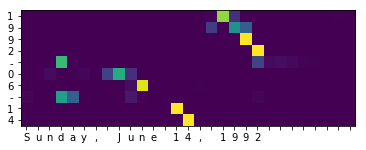

In [150]:
fig, ax = plt.subplots()
im = ax.imshow(matrix)
ax.set_xticks(np.arange(len(xlist)))
ax.set_yticks(np.arange(len(ylist)))
ax.set_xticklabels(xlist)
ax.set_yticklabels(ylist)